# EDA: Top 10000 Songs on Spotify

## Importing the necessary libraries:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
data = pd.read_csv('top_10000_1960-now.csv')

In [3]:
print(data.describe())

       Disc Number  Track Number  Track Duration (ms)   Popularity  \
count  9999.000000   9999.000000         9.999000e+03  9999.000000   
mean      1.035104      4.957096         2.248150e+05    37.624662   
std       0.327856      5.502810         5.410012e+04    29.460808   
min       0.000000      0.000000         0.000000e+00     0.000000   
25%       1.000000      1.000000         1.925795e+05     0.000000   
50%       1.000000      3.000000         2.199060e+05    42.000000   
75%       1.000000      7.000000         2.502600e+05    64.000000   
max      15.000000     93.000000         1.561133e+06    98.000000   

       Danceability       Energy          Key     Loudness         Mode  \
count   9997.000000  9997.000000  9997.000000  9997.000000  9997.000000   
mean       0.607925     0.683281     5.167750    -7.269217     0.698410   
std        0.145869     0.191131     3.578392     3.281731     0.458971   
min        0.000000     0.000020     0.000000   -29.368000     0.0000

## Cleaning out the unnecessary details such as unique identifiers and urls.

In [4]:
data = data.drop(['Track URI',
           'Artist URI(s)',
           'Album URI',
           'Album Artist URI(s)',
           'Album Image URL',
           'Track Preview URL',
           'Added By',
           'Album Genres',
           'Track Number',
           'Disc Number',
           'ISRC',
           'Added At',
           'Copyrights'], axis=1)

In [5]:
data.head(3)

,Track Name,Artist Name(s),Album Name,Album Artist Name(s),Album Release Date,Track Duration (ms),Explicit,Popularity,Artist Genres,Danceability,...,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label
0,Justified & Ancient - Stand by the Jams,The KLF,Songs Collection,The KLF,1992-08-03,216270,False,0,"acid house,ambient house,big beat,hip house",0.617,...,-12.305,1.0,0.0480,0.0158,0.112000,0.408,0.504,111.458,4.0,Jams Communications
1,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,Pitbull,2009-10-23,237120,False,64,"dance pop,miami hip hop,pop",0.825,...,-5.995,1.0,0.1490,0.0142,0.000021,0.237,0.800,127.045,4.0,Mr.305/Polo Grounds Music/J Records
2,From the Bottom of My Broken Heart,Britney Spears,...Baby One More Time (Digital Deluxe Version),Britney Spears,1999-01-12,312533,False,56,"dance pop,pop",0.677,...,-5.171,1.0,0.0305,0.5600,0.000001,0.338,0.706,74.981,4.0,Jive


## Finding out the NaN values.

In [6]:
nan_values = data.isna().sum()
nan_values

Track Name                1
Artist Name(s)            1
Album Name                1
Album Artist Name(s)      2
Album Release Date        2
Track Duration (ms)       0
Explicit                  0
Popularity                0
Artist Genres           550
Danceability              2
Energy                    2
Key                       2
Loudness                  2
Mode                      2
Speechiness               2
Acousticness              2
Instrumentalness          2
Liveness                  2
Valence                   2
Tempo                     2
Time Signature            2
Label                     6
dtype: int64

In [7]:
data.shape

(9999, 22)

In [8]:
album_release_date = data['Album Release Date']

if album_release_date.isna().sum() != 0:
    x = list(data.loc[pd.isna(data['Album Release Date']), :].index)
    for i in x:
        artist_name = data['Artist Name(s)'][i]
        album_name = data['Album Name'][i]
        if album_name in data[data['Artist Name(s)'] == artist_name]['Album Name']:
            data['Album Release Date'] = data[data['Artist Name(s)'] == artist_name]['Album Release Date']
        else:
            #Check how many nan values do this rows contain, if it's too much we might as well drop.
            data = data.drop([i], axis=0)
else:
    pass       
data = data.reset_index(drop=True) 

In [9]:
data.shape

(9997, 22)

In [10]:
data.isna().sum()

Track Name                1
Artist Name(s)            1
Album Name                1
Album Artist Name(s)      0
Album Release Date        0
Track Duration (ms)       0
Explicit                  0
Popularity                0
Artist Genres           548
Danceability              0
Energy                    0
Key                       0
Loudness                  0
Mode                      0
Speechiness               0
Acousticness              0
Instrumentalness          0
Liveness                  0
Valence                   0
Tempo                     0
Time Signature            0
Label                     4
dtype: int64

In [11]:
l = data.loc[pd.isna(data['Track Name']), :].index[0]
data = data.drop([l], axis = 0).reset_index(drop=True)

In [12]:
data.isna().sum()

Track Name                0
Artist Name(s)            0
Album Name                0
Album Artist Name(s)      0
Album Release Date        0
Track Duration (ms)       0
Explicit                  0
Popularity                0
Artist Genres           547
Danceability              0
Energy                    0
Key                       0
Loudness                  0
Mode                      0
Speechiness               0
Acousticness              0
Instrumentalness          0
Liveness                  0
Valence                   0
Tempo                     0
Time Signature            0
Label                     3
dtype: int64

## We're gonna change 'Album Release Date' to Years by splitting.

In [13]:
data['Album Release Date'].head(3)

0    1992-08-03
1    2009-10-23
2    1999-01-12
Name: Album Release Date, dtype: object

In [14]:
years_dict = {}
for k, v in data.iterrows():
    #Check if it's already in year form or not.
    if "-" in v['Album Release Date']:
        new_val = v['Album Release Date'].split("-")[0]
        years_dict.update({k:new_val})
    else:
        years_dict.update({k:new_val})    
years_df = pd.DataFrame.from_dict(years_dict, orient='index', columns=['Album Release Date'])

In [15]:
data['Album Release Date'] = years_df['Album Release Date']

In [16]:
data['Album Release Date'].head(3)

0    1992
1    2009
2    1999
Name: Album Release Date, dtype: object

## Finding out which years have more popular songs.

In [17]:
year_count = data['Album Release Date'].value_counts()

Text(0, 0.5, 'Count')

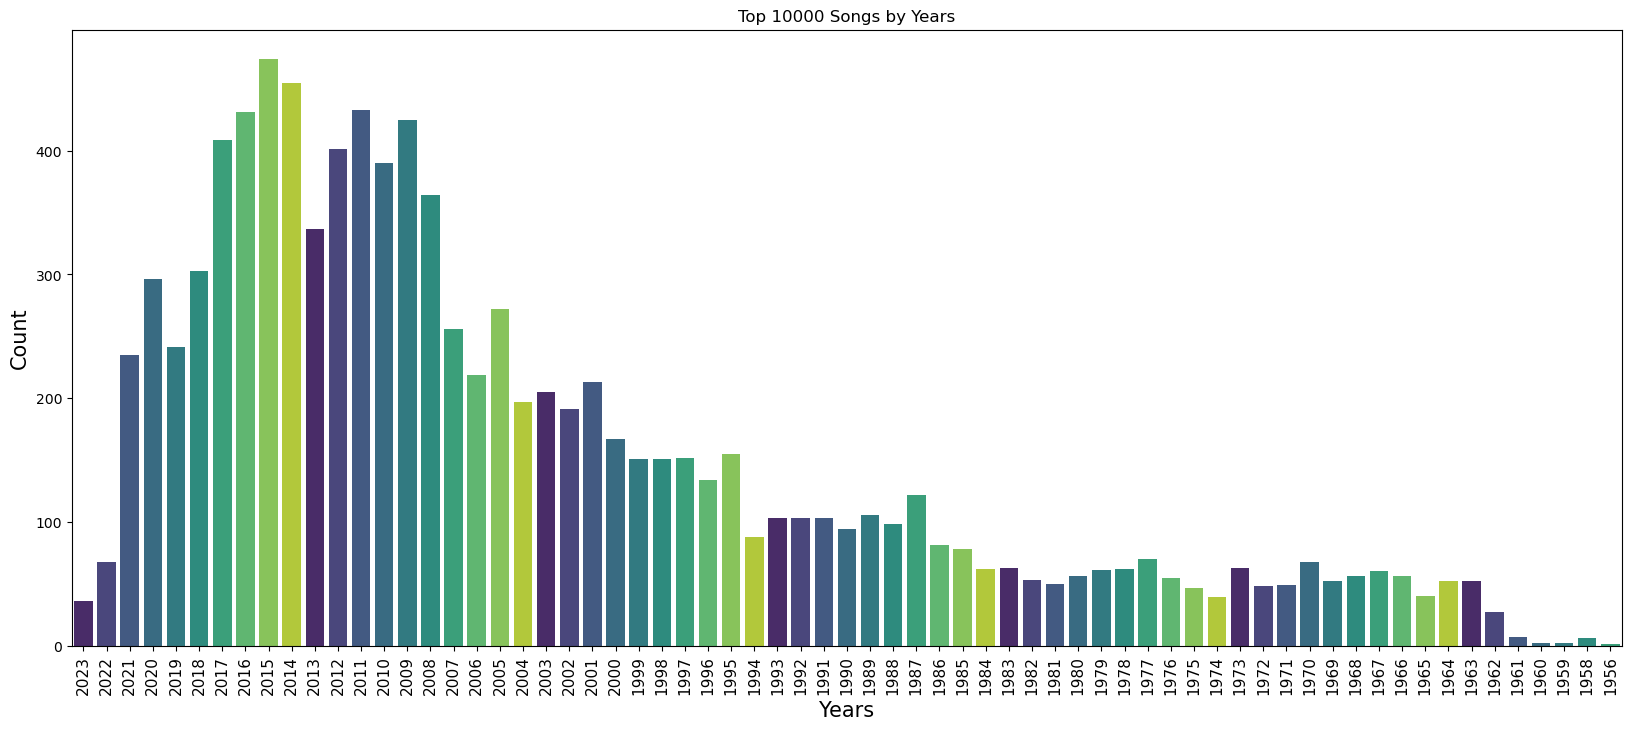

In [18]:
palette_bae = sns.color_palette("viridis", 10)

plt.figure(figsize=(20,8))
plt.xticks(fontsize=11, rotation=90)
plt.xlabel('Years', fontsize=15)
plt.title('Top 10000 Songs by Years')
"Using the same colors every 10 years."
sns.barplot(x=year_count.keys(), y=year_count, order=sorted(year_count.keys(), reverse=True), palette=palette_bae)
plt.ylabel('Count', fontsize=15)

#### 2015 and 2014 do have quite songs, huh?

## Now, we're gonna find out the genre information.

In [19]:
genre_dict = {}
for v in data['Artist Genres']:
    if (type(v) == str):
        if ',' in v:
            for i in v.split(','):
                i = i.title()
                if i in genre_dict.keys():
                    genre_dict.update({i: genre_dict.get(i)+1})
                else:
                    genre_dict.update({i: 1})
        else:
            i = i.title()
            if i in genre_dict.keys():
                genre_dict.update({i: genre_dict.get(i)+1})
            else:
                genre_dict.update({i: 1})
    else:
        pass

In [20]:
N = 10
genre_dict = dict(sorted(genre_dict.items(), key = lambda x: x[1], reverse = True)[:N])

In [21]:
genre_dict

{'Pop': 2598,
 'Dance Pop': 1535,
 'Rock': 1458,
 'Soft Rock': 1001,
 'Classic Rock': 852,
 'Mellow Gold': 744,
 'Album Rock': 618,
 'Rap': 594,
 'New Wave Pop': 581,
 'Urban Contemporary': 530}

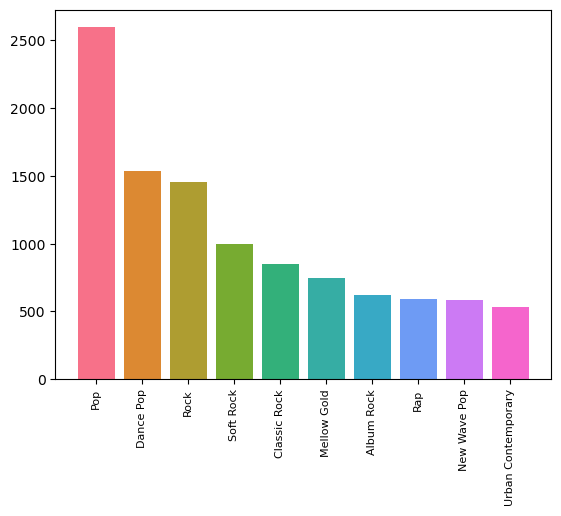

In [22]:
ind = np.arange(len(genre_dict))
palette = sns.color_palette("husl", len(genre_dict))

plt.bar(ind, list(genre_dict.values()), color=palette)
plt.xticks(ind, list(genre_dict.keys()))
plt.xticks(fontsize=8, rotation=90)
plt.show()

## Let's see which artists have more popular songs.

<BarContainer object of 15 artists>

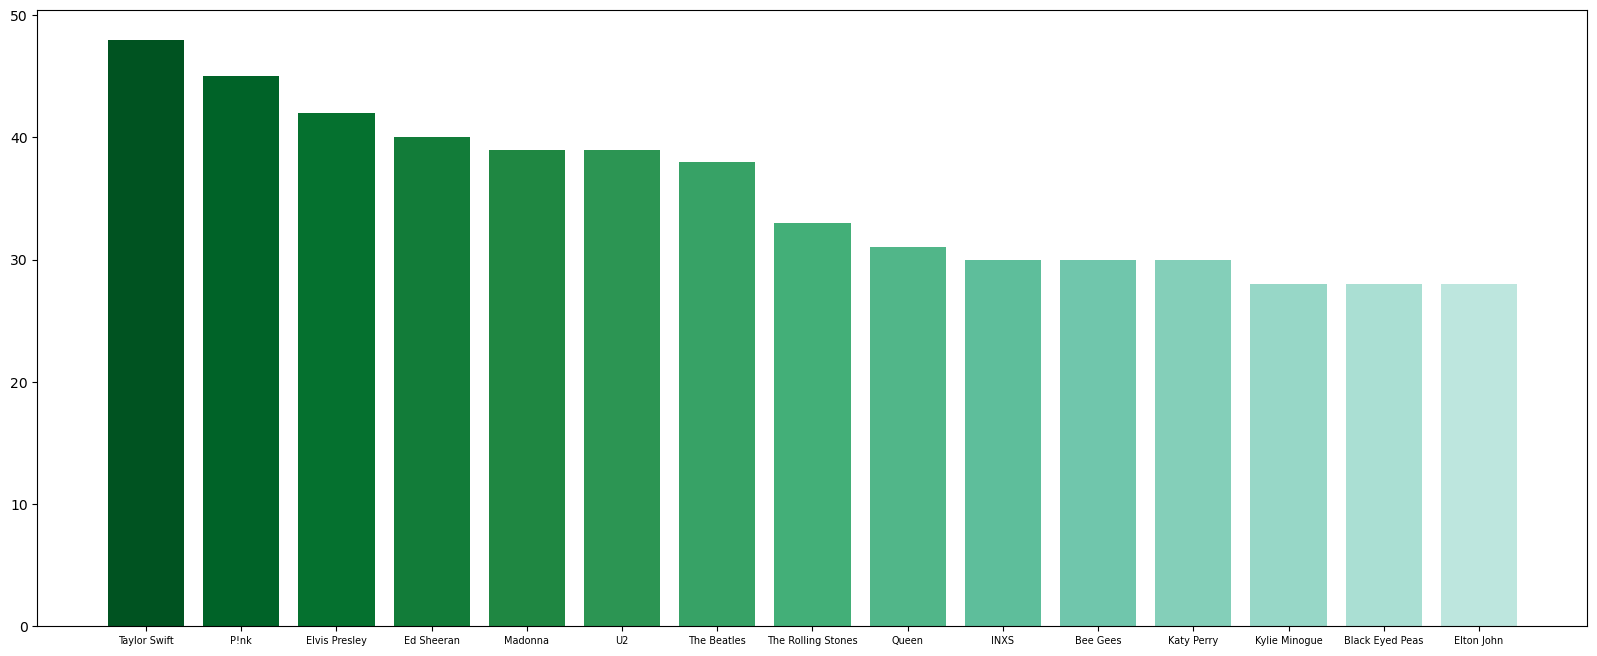

In [23]:
artist_count = data['Artist Name(s)'].value_counts()
top_15 = artist_count.head(15)

palette_2 = sns.color_palette("BuGn_r", 20)

plt.figure(figsize=(20,8))
plt.xticks(fontsize=7, rotation=0)
plt.bar(top_15.keys(), top_15, color=palette_2)

## What about the correlation between the metrics of them.

In [24]:
correlation_cols = ['Danceability', 'Energy', 'Speechiness',
                    'Acousticness', 'Instrumentalness',
                    'Liveness', 'Valence', 'Loudness']

In [25]:
corr_df = data.loc[:,correlation_cols]

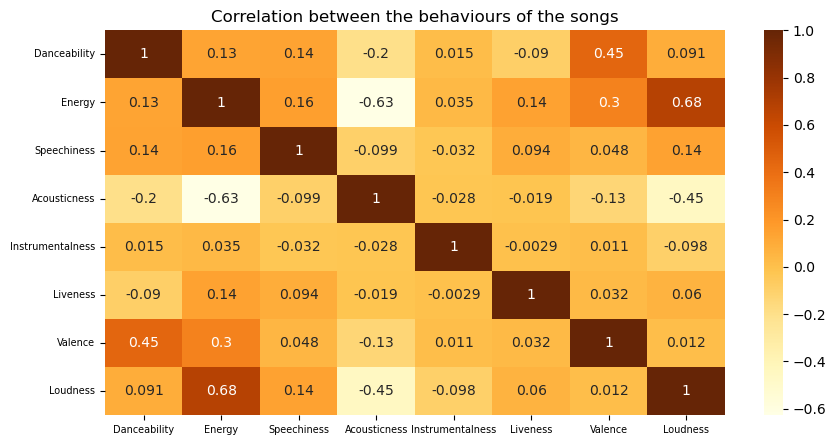

In [26]:
plt.figure(figsize=(10,5))
dataplot = sns.heatmap(corr_df.corr(), annot=True, cmap='YlOrBr')
plt.xticks(fontsize=7, rotation=0)
plt.yticks(fontsize=7)
plt.title('Correlation between the behaviours of the songs')
plt.show()

#### Acousticness and Energy have a negative impact on each other, whilst Loudness and Energy have quite positive relationship.